In [11]:
%load_ext autoreload
%autoreload 2
from ais_dataloader import *
from gp_kernel_ship_classification_dataset import *
from gp_kernel_ship_classification_trainer import *
from gp_kernel_ship_classification_network import *
from multioutput_rbf_linear_gp import *


import ipywidgets as widgets
from IPython.display import display
from plotting_utils import *
from tqdm.notebook import tqdm
from IPython.display import clear_output
import time
import os
import torch
import gpytorch
import datetime
import seaborn as sns


# sns.set(style="whitegrid")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cpu


## Load Data

Combining AIS CSVs into a single df: 100%|██████████| 2/2 [00:15<00:00,  7.87s/it]


Processing AIS data...
Removed 10256799 out of 14591891 rows due to invalid COG, SOG, LAT, or Heading values.
Saved processed dataset to: data/processed/processed_AIS_df_2024_01_01_2024_01_02.pkl


Scaling trajectories for each MMSI: 100%|██████████| 3850/3850 [00:01<00:00, 2855.98it/s]



===== Dataset Statistics =====
Total number of AIS messages: 4335092
Number of unique MMSIs: 3850
Date range: 2024-01-01 00:00:00 to 2024-01-02 23:59:59
Number of vessel groups: 9


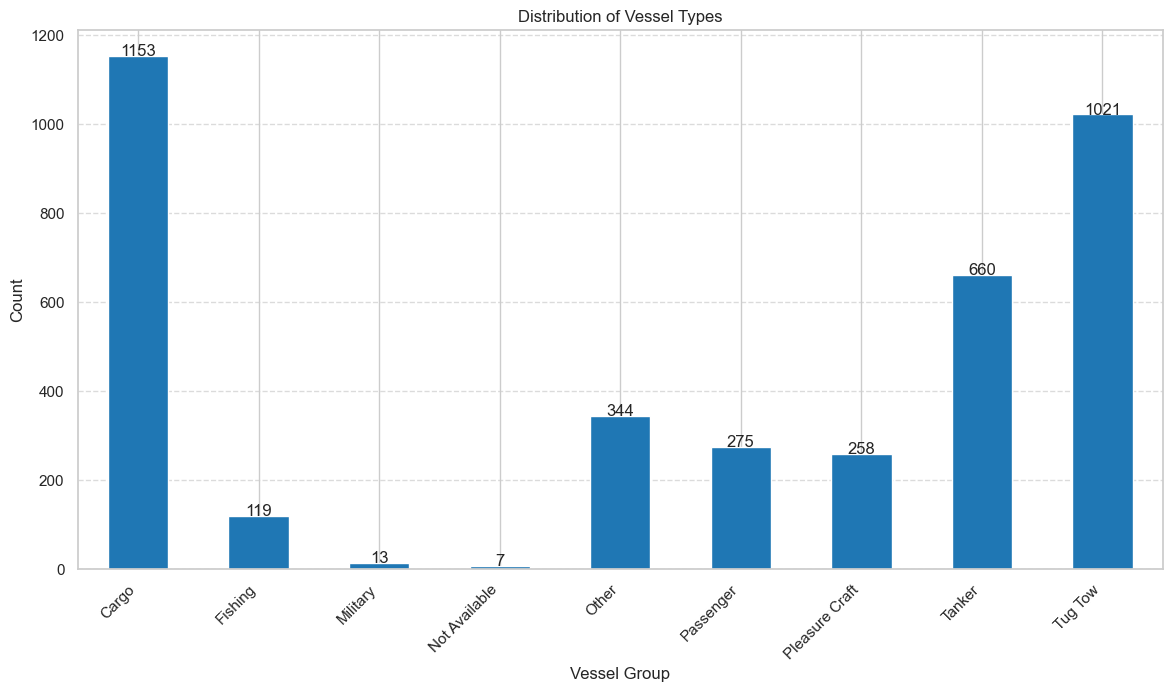

In [14]:
date_range = pd.date_range(start='2024-01-01', end='2024-01-02', freq='D')
gp_regression_dataset = AISTrajectoryRegressionDataset(date_range, device)

# Display vessel group histogram
group_counts = gp_regression_dataset.plot_vessel_group_histogram(figsize=(14, 7))

# Print group to ID mapping for reference

# print("\nVessel Group to ID mapping:")
# for group, group_id in gp_regression_dataset.vessel_group_to_id.items():
#     print(f"  {group}: {group_id}")

## Fit GP Models

In [ ]:
# Control flag - set to True to load existing models if available, False to force retraining
reload_existing_models = True

num_trajectories = len(gp_regression_dataset)
# num_trajectories = 1000  # For testing, set to 1 to avoid long training times
models = {}
likelihoods = {}
losses = {}

# Create a filename based on the dataset's date range and number of trajectories
start_date = date_range[0].strftime('%Y-%m-%d')
end_date = date_range[-1].strftime('%Y-%m-%d')

# If it's a single day, use just one date, otherwise show the range
if start_date == end_date:
    date_identifier = start_date
else:
    date_identifier = f"{start_date}_to_{end_date}"

# Define model file path with number of trajectories included
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)
save_path = f"{save_dir}/rbf_and_linear_kernel_classification_bundle_{date_identifier}_n{num_trajectories}.pt"

# Check if models with current num_trajectories already exist
if os.path.exists(save_path) and reload_existing_models:
    print(f"Found existing model bundle for date range {date_identifier} with {num_trajectories} trajectories")
    print(f"Loading models from {save_path} instead of retraining...")
    
    # Load the existing models
    bundle = torch.load(save_path)
    models_state_dict = bundle["models_state_dict"]
    likelihoods_state_dict = bundle["likelihoods_state_dict"] 
    losses = bundle.get("losses", {})
    
    # Verify the model count matches expected count
    if len(models_state_dict) != num_trajectories:
        print(f"Warning: Loaded {len(models_state_dict)} models but expected {num_trajectories}")
    
    # Reconstruct models from state dictionaries
    for mmsi, state_dict in tqdm(models_state_dict.items(), desc="Loading models"):
        # Get the corresponding data for this MMSI
        times, state_trajectory = None, None
        for entry in gp_regression_dataset:
            if entry[0] == mmsi:
                _, times, state_trajectory = entry
                break
        if times is None:
            print(f"Warning: Could not find data for MMSI {mmsi}, skipping")
            continue

        X = times.detach().unsqueeze(1).to(device)
        Y = state_trajectory.detach().to(device)
        num_outputs = Y.shape[1]
        
        likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
            num_tasks=num_outputs
        ).to(device)
        
        model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)
        
        # Load the state dictionaries
        model.load_state_dict(state_dict)
        if mmsi in likelihoods_state_dict:
            likelihood.load_state_dict(likelihoods_state_dict[mmsi])
        
        models[mmsi] = model
        likelihoods[mmsi] = likelihood
    
    print(f"Successfully loaded {len(models)} models")

else:
    # Check if we need to train new models
    if os.path.exists(save_path) and not reload_existing_models:
        print(f"Models exist at {save_path} but reload_existing_models=False, retraining...")
    else:
        print(f"No existing models found for date range {date_identifier} with {num_trajectories} trajectories")
    
    print("Starting training process...")
    
    # Track timing information for ETA calculation
    start_time = time.time()
    processed_count = 0
    avg_time_per_model = None

    # Create outer progress bar for overall tracking
    overall_pbar = tqdm(total=num_trajectories, desc="Overall Progress", position=0)

    try:
        for idx in range(num_trajectories):
            # Clear previous iteration output
            clear_output(wait=True)
            
            # Recalculate and display ETA
            if processed_count > 0:
                elapsed = time.time() - start_time
                avg_time_per_model = elapsed / processed_count
                remaining_models = num_trajectories - processed_count
                eta_seconds = avg_time_per_model * remaining_models
                eta_str = time.strftime("%H:%M:%S", time.gmtime(eta_seconds))
                
                # Display progress summary
                print(f"Fitting GP Models: {processed_count}/{num_trajectories} completed")
                print(f"Average time per model: {avg_time_per_model:.2f} seconds")
                print(f"Estimated time remaining: {eta_str}")
            else:
                print(f"Fitting GP Models: Starting...")
            
            # Show overall progress bar
            overall_pbar.display()
            
            # Get data for current model
            mmsi, times, state_trajectory = gp_regression_dataset[idx]
            print(f"\nFitting model for MMSI {mmsi} (#{idx+1}/{num_trajectories})")
            
            X = times.detach().unsqueeze(1).to(device)
            Y = state_trajectory.detach().to(device)
            
            num_outputs = Y.shape[1]
            
            likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
                num_tasks=num_outputs, 
                # noise_prior=gpytorch.priors.NormalPrior(loc=0.25, scale=0.25)
            ).to(device)
            
            model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)

            session_id = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

            with gpytorch.settings.cholesky_jitter(1e-3):
                loss, model, likelihood = train_model(model, likelihood, X, Y, num_epochs=50, lr=0.1, mmsi=mmsi, session_id=session_id)
            
            # Store results
            models[mmsi] = model
            likelihoods[mmsi] = likelihood
            losses[mmsi] = loss.item()
            
            # Update counters and progress
            processed_count += 1
            overall_pbar.update(1)
            
    finally:
        overall_pbar.close()

    # Display completion message with timing stats
    total_time = time.time() - start_time
    hours, remainder = divmod(total_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    clear_output(wait=True)
    print(f"Model fitting complete! {len(models)}/{num_trajectories} models successfully fit")
    print(f"Total time elapsed: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")
    print(f"Average time per model: {total_time/processed_count:.2f} seconds")

    # Save models with date range in filename and include trajectory count
    save_dict = {
        "models_state_dict": {k: v.state_dict() for k, v in models.items()},
        "likelihoods_state_dict": {k: v.state_dict() for k, v in likelihoods.items()},
        "losses": losses,
        "date_range": [start_date, end_date],
        "num_trajectories": num_trajectories  # Store trajectory count in the file
    }

    torch.save(save_dict, save_path)
    print(f"Saved model bundle to {save_path}")

Fitting GP Models: 1201/3850 completed
Average time per model: 21.35 seconds
Estimated time remaining: 15:42:29

Fitting model for MMSI 366193000 (#1202/3850)


In [ ]:
# def find_existing_bundle(date_range, target_n_trajectories, save_dir="models"):
#     """
#     Find the best existing bundle with the same date range but fewer trajectories.
    
#     Args:
#         date_range: pandas.DatetimeIndex with the date range
#         target_n_trajectories: Target number of trajectories
#         save_dir: Directory where model bundles are saved
        
#     Returns:
#         Path to the best existing bundle, or None if none found
#     """
#     import os
#     import glob
#     import re
    
#     # Determine date identifier from date range
#     start_date = date_range[0].strftime('%Y-%m-%d')
#     end_date = date_range[-1].strftime('%Y-%m-%d')
    
#     if start_date == end_date:
#         date_identifier = start_date
#     else:
#         date_identifier = f"{start_date}_to_{end_date}"
    
#     # Create pattern to search for matching files
#     pattern = f"{save_dir}/rbf_and_linear_kernel_classification_bundle_{date_identifier}_n*.pt"
    
#     # Find all matching files
#     matching_files = glob.glob(pattern)
    
#     if not matching_files:
#         print(f"No existing bundles found for date range {date_identifier}")
#         return None
    
#     # Extract trajectory counts from filenames
#     counts_and_files = []
#     for file_path in matching_files:
#         match = re.search(r"_n(\d+)\.pt$", file_path)
#         if match:
#             count = int(match.group(1))
#             counts_and_files.append((count, file_path))
    
#     # Find the file with the highest count that's less than the target
#     best_count = 0
#     best_file = None
    
#     for count, file_path in counts_and_files:
#         if count < target_n_trajectories and count > best_count:
#             best_count = count
#             best_file = file_path
    
#     if best_file:
#         print(f"Found existing bundle with {best_count} trajectories (target: {target_n_trajectories})")
#         return best_file
#     else:
#         print(f"No suitable existing bundles found with fewer than {target_n_trajectories} trajectories")
#         return None
    
# def load_and_continue_training(date_range, target_n_trajectories, existing_bundle_path=None, 
#                                model_type='RBFLinear', num_epochs=50, lr=0.1):
#     """
#     Load existing trained models and continue training for additional MMSIs
    
#     Args:
#         date_range: Date range for the dataset
#         target_n_trajectories: Total number of trajectories to have
#         existing_bundle_path: Path to existing model bundle
#         model_type: Type of model to create ('RBFLinear' or 'StateSpace')
#         num_epochs: Number of epochs to train new models
#         lr: Learning rate for training
    
#     Returns:
#         models, likelihoods, losses dictionaries
#     """
#     import os
#     import torch
#     import gpytorch
#     import datetime
#     from datetime import datetime
#     from tqdm.notebook import tqdm
    
#     # Initialize containers
#     models = {}
#     likelihoods = {}
#     losses = {}
    
#     # Create dataset to get all available MMSIs
#     gp_regression_dataset = AISTrajectoryRegressionDataset(date_range, device)
#     all_mmsis = gp_regression_dataset.get_all_mmsis()
#     print(f"Total available MMSIs: {len(all_mmsis)}")
    
#     # Load existing bundle if provided
#     existing_mmsis = []
#     if existing_bundle_path and os.path.exists(existing_bundle_path):
#         print(f"Loading existing bundle: {existing_bundle_path}")
#         try:
#             saved_bundle = torch.load(existing_bundle_path)
            
#             # Extract models and metadata
#             if "models_state_dict" in saved_bundle:
#                 # Get MMSIs from the models
#                 existing_mmsis = list(saved_bundle["models_state_dict"].keys())
#                 print(f"Found {len(existing_mmsis)} existing trained models")
                
#                 # Convert string MMSIs to integers if needed
#                 existing_mmsis = [int(mmsi) if isinstance(mmsi, str) else mmsi for mmsi in existing_mmsis]
                
#                 # Create progress bar for loading
#                 pbar = tqdm(existing_mmsis, desc="Loading existing models")
                
#                 # Load the models
#                 for mmsi in pbar:
#                     state_dict = saved_bundle["models_state_dict"][mmsi]
                    
#                     # Need to create model with right structure first
#                     # Get trajectory data for this MMSI
#                     found = False
#                     for idx in range(len(gp_regression_dataset)):
#                         m, times, state_trajectory = gp_regression_dataset[idx]
#                         if m == mmsi:
#                             found = True
#                             break
                    
#                     if found:
#                         X = times.detach().unsqueeze(1).to(device)
#                         Y = state_trajectory.detach().to(device)
#                         num_outputs = Y.shape[1]
                        
#                         # Create model structure
#                         likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_outputs).to(device)
#                         model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)
                    
#                         # Load saved state
#                         model.load_state_dict(state_dict)
#                         if "likelihoods_state_dict" in saved_bundle and mmsi in saved_bundle["likelihoods_state_dict"]:
#                             likelihood.load_state_dict(saved_bundle["likelihoods_state_dict"][mmsi])
                        
#                         # Store in dictionaries
#                         models[mmsi] = model
#                         likelihoods[mmsi] = likelihood
                        
#                         if "losses" in saved_bundle and mmsi in saved_bundle["losses"]:
#                             losses[mmsi] = saved_bundle["losses"][mmsi]
#                         else:
#                             losses[mmsi] = float('inf')
            
#             print(f"Successfully loaded {len(models)} models")
            
#         except Exception as e:
#             print(f"Error loading bundle: {e}")
#             import traceback
#             traceback.print_exc()
    
#     # Determine how many more models to train
#     n_to_train = target_n_trajectories - len(models)
#     if n_to_train <= 0:
#         print(f"Already have {len(models)} models, which meets or exceeds target of {target_n_trajectories}")
#         return models, likelihoods, losses
    
#     # Find MMSIs that haven't been trained yet
#     mmsis_to_train = [mmsi for mmsi in all_mmsis if mmsi not in existing_mmsis]
#     print(f"Need to train {n_to_train} more models. {len(mmsis_to_train)} candidates available.")
    
#     if len(mmsis_to_train) < n_to_train:
#         print(f"Warning: Only {len(mmsis_to_train)} new MMSIs available, less than requested {n_to_train}")
    
#     # Train models for additional MMSIs
#     mmsis_to_train = mmsis_to_train[:n_to_train]
#     session_id = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    
#     # Create progress bar for new training
#     pbar = tqdm(mmsis_to_train, desc="Training new models")
    
#     for mmsi in pbar:
#         pbar.set_description(f"Training MMSI {mmsi}")
        
#         # Find this MMSI in the dataset
#         for idx in range(len(gp_regression_dataset)):
#             m, times, state_trajectory = gp_regression_dataset[idx]
#             if m == mmsi:
#                 break
        
#         # Prepare data based on model type
#         try:
#             X = times.detach().unsqueeze(1).to(device)
#             Y = state_trajectory.detach().to(device)
#             num_outputs = Y.shape[1]
            
#             # Create model
#             likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_outputs).to(device)
#             model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)
        
#             # Train model
#             with gpytorch.settings.cholesky_jitter(1e-3):
#                 loss, model, likelihood = train_model(
#                     model, likelihood, X, Y, 
#                     num_epochs=num_epochs, lr=lr, 
#                     mmsi=mmsi, session_id=session_id
#                 )
            
#             models[mmsi] = model
#             likelihoods[mmsi] = likelihood
#             losses[mmsi] = loss.item()
            
#         except Exception as e:
#             print(f"Error training model for MMSI {mmsi}: {e}")
#             continue
    
#     # Save the updated bundle
#     if existing_bundle_path:
#         # Create new filename based on the number of models
#         match = re.search(r"_n(\d+)\.pt$", existing_bundle_path)
#         if match:
#             count = int(match.group(1))
#             new_save_path = existing_bundle_path.replace(f"_n{count}.pt", f"_n{len(models)}.pt")
#         else:
#             new_save_path = existing_bundle_path.replace(".pt", f"_n{len(models)}.pt")
#     else:
#         # Create a new filename
#         start_date = date_range[0].strftime('%Y-%m-%d')
#         end_date = date_range[-1].strftime('%Y-%m-%d')
        
#         if start_date == end_date:
#             date_identifier = start_date
#         else:
#             date_identifier = f"{start_date}_to_{end_date}"
        
#         save_dir = "models"
#         os.makedirs(save_dir, exist_ok=True)
#         new_save_path = f"{save_dir}/rbf_and_linear_kernel_classification_bundle_{date_identifier}_n{len(models)}.pt"
    
#     # Save the bundle
#     save_dict = {
#         "models_state_dict": {k: v.state_dict() for k, v in models.items()},
#         "likelihoods_state_dict": {k: v.state_dict() for k, v in likelihoods.items()},
#         "losses": losses,
#         "date_range": [date_range[0].strftime('%Y-%m-%d'), date_range[-1].strftime('%Y-%m-%d')],
#         "num_trajectories": len(models),

#     }
    
    
#     torch.save(save_dict, new_save_path)
#     print(f"Saved updated bundle with {len(models)} models to {new_save_path}")
    
#     return models, likelihoods, losses

In [ ]:


# target_trajectories = 1
# # 1. First try to find an existing bundle with the same date range but fewer trajectories
# existing_bundle_path = find_existing_bundle(date_range, target_trajectories)

# # 2. Load existing models and train additional ones if needed
# if existing_bundle_path:
#     # RBF and Linear model type
#     models, likelihoods, losses = load_and_continue_training(
#         date_range=date_range,
#         target_n_trajectories=target_trajectories,
#         existing_bundle_path=existing_bundle_path,
#         model_type='RBFLinear',  # Or 'StateSpace' for state space models
#         num_epochs=50,
#         lr=0.1
#     )
#     print(f"Total models after continuing training: {len(models)}")
# else:
#     # No suitable existing bundle found, start from scratch
#     print("No suitable existing bundle found. Training from scratch...")
#     # Your training from scratch code here...
#     # For example:
#     models, likelihoods, losses = load_and_continue_training(
#         date_range=date_range,
#         target_n_trajectories=target_trajectories,
#         existing_bundle_path=None,  # No existing bundle
#         model_type='RBFLinear',
#         num_epochs=50,
#         lr=0.1
#     )
#     print(f"Total models after training from scratch: {len(models)}")



No suitable existing bundles found with fewer than 1 trajectories
No suitable existing bundle found. Training from scratch...
Loading cached dataframe from data/processed/processed_AIS_df_2024_01_01_2024_01_01.pkl


Scaling trajectories for each MMSI: 100%|██████████| 3453/3453 [00:01<00:00, 3243.07it/s]


===== Dataset Statistics =====
Total number of AIS messages: 2128288
Number of unique MMSIs: 3453
Date range: 2024-01-01 00:00:00 to 2024-01-01 23:59:59
Total available MMSIs: 3453
Need to train 1 more models. 3453 candidates available.


Training new models:   0%|          | 0/1 [00:00<?, ?it/s]

Saved updated bundle with 1 models to models/rbf_and_linear_kernel_classification_bundle_2024-01-01_n1.pt
Total models after training from scratch: 1


### Load Models if already fit

In [9]:
# bundle = torch.load("kernel_classification_bundle.pt", weights_only=False)
# kernel_classification_dataset = bundle["kernel_classification_dataset"]
# models_state_dict = bundle["models_state_dict"]
# likelihoods_state_dict = bundle["likelihoods_state_dict"]
# losses = bundle["losses"]


In [10]:
# from multioutput_rbf_linear_gp import MultiOutputExactGPModel
# import gpytorch

# models = {}
# for mmsi, state_dict in tqdm(models_state_dict.items(), desc="Loading models"):
#     # Get the corresponding data for this MMSI (adjust as needed)
#     # If your dataset supports indexing by MMSI:
#     # _, times, state_trajectory = gp_regression_dataset[mmsi]
#     # If not, you may need to search for the right entry:
#     times, state_trajectory = None, None
#     for entry in gp_regression_dataset:
#         if entry[0] == mmsi:
#             _, times, state_trajectory = entry
#             break
#     if times is None:
#         continue  # skip if MMSI not found

#     X = times.detach().unsqueeze(1).to(device)
#     Y = state_trajectory.detach().to(device)
#     num_outputs = Y.shape[1]
#     likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_outputs).to(device)
#     model = MultiOutputExactGPModel(X, Y, likelihood, num_outputs=num_outputs).to(device)
#     model.load_state_dict(state_dict, strict=False)
#     models[mmsi] = model

### View the kernel parameters of the first model

In [11]:
model = next(iter(models.values()))  # Get one of the models for demonstration
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.tolist()}')
    
# print()
# print(model.covar_module.data_covar_module.kernels[0].lengthscale.item())
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

Parameter name: likelihood.raw_task_noises                 value = [-0.45829373598098755, -0.40521514415740967, -0.5071281790733337, -0.37111741304397583, -0.5067406296730042, -0.5076672434806824]
Parameter name: likelihood.raw_noise                       value = [-0.49265846610069275]
Parameter name: mean_module.base_means.0.raw_constant      value = 0.09970027953386307
Parameter name: mean_module.base_means.1.raw_constant      value = -0.08868623524904251
Parameter name: mean_module.base_means.2.raw_constant      value = 0.00029586770688183606
Parameter name: mean_module.base_means.3.raw_constant      value = 0.00010291425860486925
Parameter name: mean_module.base_means.4.raw_constant      value = 0.00023743335623294115
Parameter name: mean_module.base_means.5.raw_constant      value = -0.0020240405574440956
Parameter name: covar_module.task_covar_module.covar_factor value = [[0.7152479887008667], [0.04727381467819214], [0.008950814604759216], [0.16344818472862244], [-0.0059141409583

In [12]:
# Set the model and likelihood to evaluation mode
model.eval()
likelihood.eval()

# Generate test inputs (e.g., evenly spaced time points)
test_times = torch.linspace(times.min(), times.max(), 200).unsqueeze(1).to(device)

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_jitter(1e-3):
    predictions = likelihood(model(test_times))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()



### Plot GP Solution

In [13]:
# model.eval()
# likelihood.eval()
# from plotting_utils import *

# for mmsi in models:
#     model = models[mmsi]
#     likelihood = likelihoods[mmsi]
#     # Get the corresponding data for this MMSI
#     # If you want to use the same train/test split as before:
#     times, state_trajectory = None, None
#     for entry in gp_regression_dataset:
#         if entry[0] == mmsi:
#             _, times, state_trajectory = entry
#             break
#     if times is None:
#         continue  # skip if MMSI not found

#     train_X = times.clone().detach().unsqueeze(1).cpu()
#     train_Y = state_trajectory.clone().detach().cpu()

#     test_X = torch.linspace(times.min(), times.max(), 500).unsqueeze(1).to(device)
    
#     test_Y = eval_model(model, likelihood, test_X)

#     plot_gp(train_X, train_Y, test_X, test_Y)
#     plot_single_ship_path(mmsi, times, state_trajectory.cpu())


In [ ]:
# # import ipywidgets as widgets
# # from IPython.display import display, clear_output
# # from plotting_utils import *


# def plot_for_mmsi(selected_mmsi):
#     plt.close('all')
#     clear_output(wait=True)
#     model = models[selected_mmsi]
#     likelihood = likelihoods[selected_mmsi]
#     # Get the corresponding data for this MMSI
#     times, state_trajectory = None, None
#     for entry in gp_regression_dataset:
#         if entry[0] == selected_mmsi:
#             _, times, state_trajectory = entry
#             break
#     if times is None:
#         print("No data for MMSI:", selected_mmsi)
#         return

#     train_X = times.clone().detach().unsqueeze(1).cpu()
#     train_Y = state_trajectory.clone().detach().cpu()
#     test_X = torch.linspace(times.min(), times.max(), 500).unsqueeze(1).to(device)
#     test_Y = eval_model(model, likelihood, test_X)

#     plot_gp(train_X, train_Y, test_X, test_Y)
#     plot_single_ship_path(selected_mmsi, times, state_trajectory.cpu())

    
# mmsi_dropdown = widgets.Dropdown(
#     options=list(models.keys()),
#     description='MMSI:',
#     disabled=False,
# )

# widgets.interact(plot_for_mmsi, selected_mmsi=mmsi_dropdown)
    
    

interactive(children=(Dropdown(description='MMSI:', options=(3660489, 203661016, 205691000, 205717000, 2091560…

<function __main__.plot_for_mmsi(selected_mmsi)>

## Create the kernel param to ship mmsi dataset


In [30]:
kernel_classification_dataset = GPKernelShipClassificationDataset(gp_regression_dataset, models, device, scalers_by_mmsi=gp_regression_dataset.scalers_by_mmsi)
unique_group_ids = kernel_classification_dataset.get_unique_group_ids()

num_params = len(kernel_classification_dataset.get_parameter_names())

train_classification_dataset, test_classification_dataset = torch.utils.data.random_split(kernel_classification_dataset, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train_classification_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_classification_dataset, batch_size=32, shuffle=False)

## Train the classification model

In [32]:
from gp_kernel_ship_classification_network import GPKernelShipClassificationNetwork
model = GPKernelShipClassificationNetwork(input_dim=num_params, num_classes=max(unique_group_ids) + 1).to(device)  # +1 for background class

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trainer = GPKernelShipClassificationTrainer(model, train_loader, test_loader, criterion, optimizer, device)
trainer.train(num_epochs=1000)

GP Kernel Ship Classification Training: 100%|██████████| 1000/1000 [00:50<00:00, 19.73it/s]


## Classification Predictions

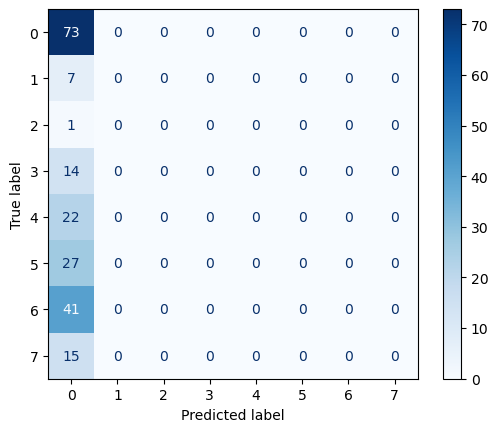

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        mmsi, X, y = batch  # adjust if your batch is structured differently
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import SubsetRandomSampler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure k-fold cross validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store metrics across folds
all_preds = []
all_labels = []
fold_accuracies = []

# Get all indices
dataset_size = len(kernel_classification_dataset)
indices = list(range(dataset_size))

print(f"Starting {k_folds}-fold cross validation on {dataset_size} samples")

# K-fold cross validation
for fold, (train_ids, test_ids) in enumerate(kfold.split(indices)):
    print(f"\nFold {fold+1}/{k_folds}")
    
    # Create data samplers for train and test
    train_sampler = SubsetRandomSampler(train_ids)
    test_sampler = SubsetRandomSampler(test_ids)
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        kernel_classification_dataset, batch_size=32, 
        sampler=train_sampler
    )
    test_loader = torch.utils.data.DataLoader(
        kernel_classification_dataset, batch_size=32,
        sampler=test_sampler
    )
    
    # Get the input dimension from the dataset
    input_dim = kernel_classification_dataset.data[0][1].shape[0]
    print(f"Input dimension: {input_dim}")
    
    # Initialize model, loss function, and optimizer
    model = GPKernelShipClassificationNetwork(
        input_dim=input_dim, 
        num_classes=max(unique_group_ids) + 1
    ).to(device)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    trainer = GPKernelShipClassificationTrainer(
        model, train_loader, test_loader, criterion, optimizer, device
    )
    trainer.train(num_epochs=200)  # Reduced epochs for quicker k-fold demo
    
    # Evaluate on the test set
    fold_preds = []
    fold_labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            mmsi, X, y = batch
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(dim=1).cpu().numpy()
            
            fold_preds.extend(preds)
            fold_labels.extend(y.cpu().numpy())
    
    # Calculate fold accuracy
    fold_accuracy = np.mean(np.array(fold_preds) == np.array(fold_labels))
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")
    
    # Add to overall results
    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

# Calculate and display overall metrics
print("\n==== Cross-Validation Results ====")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")

# Get the mapping from group IDs to group names
id_to_vessel_group = {v: k for k, v in gp_regression_dataset.vessel_group_to_id.items()}

# Get unique classes that are actually present in the predictions/labels
unique_present_classes = sorted(set(all_labels).union(set(all_preds)))

# Create class labels only for classes present in the data
class_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]

# Generate and plot the aggregate confusion matrix with proper class labels
cm = confusion_matrix(all_labels, all_preds, labels=unique_present_classes)
plt.figure(figsize=(14, 12))



Starting 5-fold cross validation on 1000 samples

Fold 1/5
Input dimension: 25


GP Kernel Ship Classification Training: 100%|██████████| 200/200 [00:02<00:00, 91.37it/s] 


Fold 1 Accuracy: 0.2250

Fold 2/5
Input dimension: 25


GP Kernel Ship Classification Training: 100%|██████████| 200/200 [00:01<00:00, 101.73it/s]


Fold 2 Accuracy: 0.2450

Fold 3/5
Input dimension: 25


GP Kernel Ship Classification Training: 100%|██████████| 200/200 [00:01<00:00, 102.93it/s]


Fold 3 Accuracy: 0.2750

Fold 4/5
Input dimension: 25


GP Kernel Ship Classification Training: 100%|██████████| 200/200 [00:02<00:00, 89.56it/s]


Fold 4 Accuracy: 0.2800

Fold 5/5
Input dimension: 25


GP Kernel Ship Classification Training: 100%|██████████| 200/200 [00:02<00:00, 99.15it/s] 

Fold 5 Accuracy: 0.2500

==== Cross-Validation Results ====
Mean Accuracy: 0.2550 ± 0.0202


<Figure size 1400x1200 with 0 Axes>

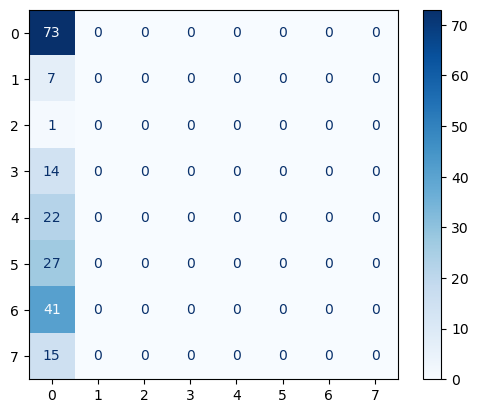

<Figure size 1400x1200 with 0 Axes>

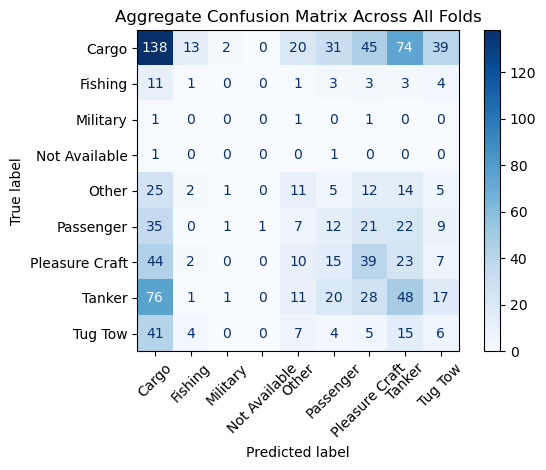


Classification Report:
                precision    recall  f1-score   support

         Cargo       0.37      0.38      0.38       362
       Fishing       0.04      0.04      0.04        26
      Military       0.00      0.00      0.00         3
 Not Available       0.00      0.00      0.00         2
         Other       0.16      0.15      0.15        75
     Passenger       0.13      0.11      0.12       108
Pleasure Craft       0.25      0.28      0.27       140
        Tanker       0.24      0.24      0.24       202
       Tug Tow       0.07      0.07      0.07        82

      accuracy                           0.26      1000
     macro avg       0.14      0.14      0.14      1000
  weighted avg       0.25      0.26      0.25      1000


Class Distribution in Dataset:
Cargo: 362 samples
Fishing: 26 samples
Military: 3 samples
Not Available: 2 samples
Other: 75 samples
Passenger: 108 samples
Pleasure Craft: 140 samples
Tanker: 202 samples
Tug Tow: 82 samples


In [35]:
import seaborn as sns 

sns.reset_orig() 
# Create the confusion matrix with class names that match the matrix dimensions
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(cmap='Blues', xticks_rotation=45)  # Rotate labels for better readability
plt.title('Aggregate Confusion Matrix Across All Folds')
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Generate classification report with descriptive class names
print("\nClassification Report:")
target_names = [id_to_vessel_group.get(i, f"Unknown ({i})") for i in unique_present_classes]
print(classification_report(all_labels, all_preds, labels=unique_present_classes, target_names=target_names))

# Print class distribution
print("\nClass Distribution in Dataset:")
class_counts = {}
for label in all_labels:
    class_name = id_to_vessel_group.get(label, f"Unknown ({label})")
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

for class_name, count in sorted(class_counts.items()):
    print(f"{class_name}: {count} samples")